In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.datacollection import DataCollector
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.patches as patches
import itertools
from matplotlib.animation import FuncAnimation

c:\Users\okwuk\social-contagion-abm\venv\Lib\site-packages\solara\validate_hooks.py:122: UserWarning: c:\Users\okwuk\social-contagion-abm\venv\Lib\site-packages\mesa\visualization\solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


In [2]:
class Party:
    def __init__(self, name, LawAndOrder, EconomicEquality, SocialWelfare, radius):
        self.name = name
        self.LawAndOrder = LawAndOrder
        self.EconomicEquality = EconomicEquality
        self.SocialWelfare = SocialWelfare
        self.radius = radius  # how tolerant/inclusive the party is

    def center_vector(self):
        """Return the party's attribute profile as a vector."""
        return np.array([self.LawAndOrder, self.EconomicEquality, self.SocialWelfare])


In [3]:
class VoterAgent(CellAgent): 
    """ Voter agent with attributes and a party preference. """

    def __init__(self, model, cell):
        super().__init__(model)

        # Attributes (named for clarity)
        self.LawAndOrder = np.random.uniform(0, 100)
        self.EconomicEquality = np.random.uniform(0, 100)
        self.SocialWelfare = np.random.uniform(0, 100)

        self.party_affiliation = "Undecided"
        self.distance = self.party_distance()
        self.susceptibility = np.random.uniform(0, 1)
        self.switched_this_step = False
        self.has_interacted = False
        self.interacted_with = None
        self.cell = cell

    # ---------------------------
    # Helper methods
    # ---------------------------

    def belief_vector(self):
        return np.array([self.LawAndOrder, self.EconomicEquality, self.SocialWelfare])

    def update_from_vector(self, vec):
        self.LawAndOrder, self.EconomicEquality, self.SocialWelfare = vec

    def assign_party(self):
        """Check which party (if any) the agent belongs to."""
        for p in self.model.parties:
            if np.linalg.norm(self.belief_vector() - p.center_vector()) <= p.radius:
                return p.name, 0.0
        undecided_center = np.array([50, 50, 50])
        return "Undecided", np.linalg.norm(self.belief_vector() - undecided_center)
    
    def party_center(self):
        if self.party_affiliation == "Undecided":
            return self.belief_vector()
        for p in self.model.parties:
            if p.name == self.party_affiliation:
                return p.center_vector()

    def party_distance(self):
        return np.linalg.norm(self.party_center() - self.belief_vector())

    def move(self):
        """ Move to a random neighboring cell. """    
        self.cell = self.cell.neighborhood.select_random_cell()

    # ---------------------------
    # Interaction Rules
    # ---------------------------

    def mutual_persuasion(self, other):
        new_self = self.belief_vector() + self.susceptibility * (other.belief_vector() - self.belief_vector())
        new_other = other.belief_vector() + other.susceptibility * (self.belief_vector() - other.belief_vector())
        return new_self, new_other

    def other_convinces_self(self, other):
        new_self = self.belief_vector() + self.susceptibility * (other.belief_vector() - self.belief_vector())
        reinforce = (other.party_center() - other.belief_vector())
        new_other = other.belief_vector() + other.susceptibility * reinforce
        return new_self, new_other

    def self_convinces_other(self, other):
        new_other = other.belief_vector() + other.susceptibility * (self.belief_vector() - other.belief_vector())
        reinforce = (self.party_center() - self.belief_vector())
        new_self = self.belief_vector() + self.susceptibility * reinforce
        return new_self, new_other

    def disagreement(self, other):  # go closer to own party center
        new_self = self.belief_vector() + self.susceptibility * (self.party_center() - self.belief_vector())
        new_other = other.belief_vector() + other.susceptibility * (other.party_center() - other.belief_vector())
        return new_self, new_other

    def choose_rule(self, other):
        """Decide which interaction rule to apply based on susceptibility."""
        if self.susceptibility > 0.3 and other.susceptibility > 0.3:
            return "mutual"
        elif self.susceptibility > 0.7 and other.susceptibility < 0.3:
            return "otherconvince"
        elif self.susceptibility < 0.3 and other.susceptibility > 0.7:
            return "selfconvince"
        else:
            return "disagree"
    
    # dictionary to define interaction rules
    interaction_rules = {
    "mutual": mutual_persuasion,
    "otherconvince": other_convinces_self,
    "selfconvince": self_convinces_other,
    "disagree": disagreement,
    }

    # def media_influence(self, media_bias):
    #    """ Influence from media. """
    #    self.political_bias = self.political_bias + self.susceptibility * media_bias

    def policy_influence(self, other):
        rule = self.choose_rule(other)
        new_self, new_other = self.interaction_rules[rule](self, other) # what's happening here?

        # Update beliefs (clamp between 0–100)
        self.update_from_vector(np.clip(new_self, 0, 100))
        other.update_from_vector(np.clip(new_other, 0, 100))

        # Update party affiliation
        old_party = self.party_affiliation
        self.party_affiliation, undecided_distance = self.assign_party()

        if(self.party_affiliation == "Undecided"):
            self.distance = undecided_distance
        else:
            self.distance = self.party_distance()

        self.switched_this_step = (self.party_affiliation != old_party)

    # ---------------------------
    # Step control
    # ---------------------------
    
    def interact(self):
        if self.has_interacted:
            return

        others = [a for a in self.cell.agents if a != self and not a.has_interacted]
        if others:
            other = self.random.choice(others)
            self.policy_influence(other)

            # mark both as having interacted
            self.has_interacted = True
            self.interacted_with = int(other.unique_id)
            other.has_interacted = True
            other.interacted_with = int(self.unique_id)

    def reset(self):
        """Reset interaction flag for this agent."""
        self.has_interacted = False
        self.switched_this_step = False

    def __repr__(self):
        return (f"Law&Order: {self.LawAndOrder:.1f}, "
                f"EconEquality: {self.EconomicEquality:.1f}, "
                f"SocWelfare: {self.SocialWelfare:.1f}, "
                f"Party: {self.party_affiliation}")

In [4]:
class Seeder:
    def __init__(self, parties, undecided_ratio=0.1, strategy="proximity"):
        """
        parties: list of party objects (with .center or .belief_vector attribute)
        undecided_ratio: float, fraction of agents to be undecided
        strategy: str, determines seeding strategy ("proximity", "fixed_split", etc.)
        """
        self.parties = parties
        self.undecided_ratio = undecided_ratio
        self.strategy = strategy

    def assign_beliefs(self, num_agents):
        if self.strategy == "proximity":
            return self._proximity_based(num_agents)
        elif self.strategy == "fixed_split":
            return self._fixed_split(num_agents)
        elif self.strategy == "equal_distribution":
            return self._equal_distribution(num_agents)
        else:
            raise ValueError(f"Unknown seeding strategy: {self.strategy}")

    def _proximity_based(self, num_agents):
        """
        Each agent starts near some party's center (Gaussian noise).
        A few go to undecided.
        """
        agents = []
        num_undecided = int(num_agents * self.undecided_ratio)
        num_decided = num_agents - num_undecided

        for _ in range(num_decided):
            party = np.random.choice(self.parties)
            vec = party.center_vector() + np.random.normal(0, 10, size=len(party.center_vector()))  # adjust spread
            agents.append((vec, party.name))

        # Undecided (sampled until they are NOT in any party radius)
        for _ in range(num_undecided):
            while True:
                vec = np.random.uniform(0, 100, size=len(self.parties[0].center_vector()))
                # Check distance from all party centers
                if all(np.linalg.norm(vec - p.center_vector()) > p.radius for p in self.parties):
                    agents.append((vec, "Undecided"))
                    break

        return agents

    def _fixed_split(self, num_agents):
        """
        Example: half to one party, rest equally split, some undecided.
        """
        agents = []
        num_undecided = int(num_agents * self.undecided_ratio)
        remaining = num_agents - num_undecided

        # Half go to first party
        first_party_count = remaining // 2
        for _ in range(first_party_count):
            vec = self.parties[0].center_vector() + np.random.normal(0, 10, size=len(self.parties[0].center_vector()))
            agents.append((vec, self.parties[0].name))

        # Rest split equally
        rest_count = remaining - first_party_count
        per_party = rest_count // (len(self.parties) - 1)
        for party in self.parties[1:]:
            for _ in range(per_party):
                vec = party.center_vector() + np.random.normal(0, 10, size=len(party.center_vector()))
                agents.append((vec, party.name))

        # Undecided (sampled until they are NOT in any party radius)
        for _ in range(num_undecided):
            while True:
                vec = np.random.uniform(0, 100, size=len(self.parties[0].center_vector()))
                # Check distance from all party centers
                if all(np.linalg.norm(vec - p.center_vector()) > p.radius for p in self.parties):
                    agents.append((vec, "Undecided"))
                    break

        return agents

    def _equal_distribution(self, num_agents):
        """
        Every party gets an equal share, no undecided (unless ratio > 0).
        """
        agents = []
        num_undecided = int(num_agents * self.undecided_ratio)
        remaining = num_agents - num_undecided
        per_party = remaining // len(self.parties)

        for party in self.parties:
            for _ in range(per_party):
                vec = party.center_vector() + np.random.normal(0, 10, size=len(party.center_vector()))
                agents.append((vec, party.name))

        # Undecided (sampled until they are NOT in any party radius)
        for _ in range(num_undecided):
            while True:
                vec = np.random.uniform(0, 100, size=len(self.parties[0].center_vector()))
                # Check distance from all party centers
                if all(np.linalg.norm(vec - p.center_vector()) > p.radius for p in self.parties):
                    agents.append((vec, "Undecided"))
                    break

        return agents


In [5]:
def num_switches(model):
    return sum(1 for a in model.agents if getattr(a, "switched_this_step", False))

def num_interactions(model):
    # count how many agents have interacted this step
    interacted = sum(1 for a in model.agents if getattr(a, "has_interacted", False))
    # each interaction sets two agents → divide by 2
    return interacted // 2

def vote_count_for(model, party_name):
    """Count how many agents are affiliated with `party_name`."""
    return sum(1 for a in model.agents if a.party_affiliation == party_name)

def vote_counts(model):
    """Return dict of counts per party (useful but not directly plotable)."""
    counts = {}
    for p in model.parties:
        counts[p.name] = vote_count_for(model, p.name)
    # You might also count “Undecided”
    counts["Undecided"] = sum(1 for a in model.agents if a.party_affiliation == "Undecided")
    return counts

def count_Conservatism(model):
    return vote_count_for(model, "Conservatism")

def count_Socialism(model):
    return vote_count_for(model, "Socialism")

def count_Liberalism(model):
    return vote_count_for(model, "Liberalism")

def count_Undecided(model):
    return vote_count_for(model, "Undecided")


In [6]:
class Environment(mesa.Model):
    """Environment with agents, parties, and interactions."""

    def __init__(self, n=5, width=3, height=3, seed=None, seeding_strategy="fixed_split", undecided_ratio=0.1):
        super().__init__()
        self.seed = seed
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), 
            torus=True, 
            capacity=40, 
            random=self.random
        )

        # Attributes
        self.attribute_names = ["LawAndOrder", "EconomicEquality", "SocialWelfare"]
        self.belief_dim = len(self.attribute_names)
        self.neutral_center = np.array([50] * self.belief_dim)

        # Parties
        self.parties = [
            Party("Conservatism", LawAndOrder=80, EconomicEquality=20, SocialWelfare=40, radius=25),
            Party("Socialism",    LawAndOrder=30, EconomicEquality=80, SocialWelfare=70, radius=25),
            Party("Liberalism",   LawAndOrder=50, EconomicEquality=50, SocialWelfare=80, radius=25),
        ]

        # --------------------------
        # NEW: Seeder Integration
        # --------------------------
        seeder = Seeder(self.parties, undecided_ratio=undecided_ratio, strategy=seeding_strategy)
        init_beliefs = seeder.assign_beliefs(self.num_agents)

        for vec, affiliation in init_beliefs:
            # Create agent (susceptibility, flags still randomized in __init__)
            agent = VoterAgent(self, cell=None)

            # Overwrite beliefs from seeder
            agent.update_from_vector(vec)

            # Recompute party affiliation and distance using agent’s logic
            if affiliation == "Undecided":
                agent.party_affiliation, undecided_distance = agent.assign_party()
                agent.distance = undecided_distance
            else:
                agent.party_affiliation = affiliation
                agent.distance = agent.party_distance()

            # Place agent on grid
            cell = self.random.choice(self.grid.all_cells.cells)
            cell.add_agent(agent)
            agent.cell = cell

        # VoterAgent.create_agents(
        #     self,
        #     self.num_agents,
        #     self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        # )

        self.datacollector = DataCollector(
            model_reporters={
                "num_switches": num_switches,
                "num_interactions": num_interactions,
                "vote_Conservatism": count_Conservatism,
                "vote_Socialism": count_Socialism,
                "vote_Liberalism": count_Liberalism,
                "vote_Undecided": count_Undecided,
            },
            agent_reporters={
                "belief_vector": lambda a: a.belief_vector().tolist(),
                "distance_from_party": lambda a: a.distance,
                "party": lambda a: a.party_affiliation,
                "susceptibility": lambda a: a.susceptibility,
                "switched": lambda a: a.switched_this_step,
                "has_interacted": lambda a: a.has_interacted,
                "interacted_with": lambda a: a.interacted_with,
            },
        )

        self.datacollector.collect(self)


    def step(self):
        """ Advance the model by one step. """
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("reset")
        self.agents.shuffle_do("interact")
        self.datacollector.collect(self)

    # def media_campaign(self, bias):
    #    """ Conduct a media campaign with a specific bias. """
    #   self.agents.do("media_influence", bias)
        

In [7]:
print(mesa.__version__)

3.3.0


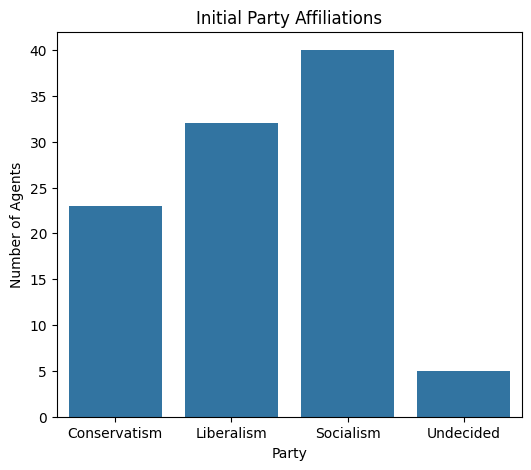

In [8]:
environment = Environment(100, 10, 10, seeding_strategy="proximity", undecided_ratio=0.05)

# Collect each agent's initial party affiliation
initial_votes = [agent.party_affiliation for agent in environment.agents]

# Count frequencies by party name
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()

# Plot
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Party Affiliations", xlabel="Party", ylabel="Number of Agents")
p.figure.set_size_inches(6, 5)


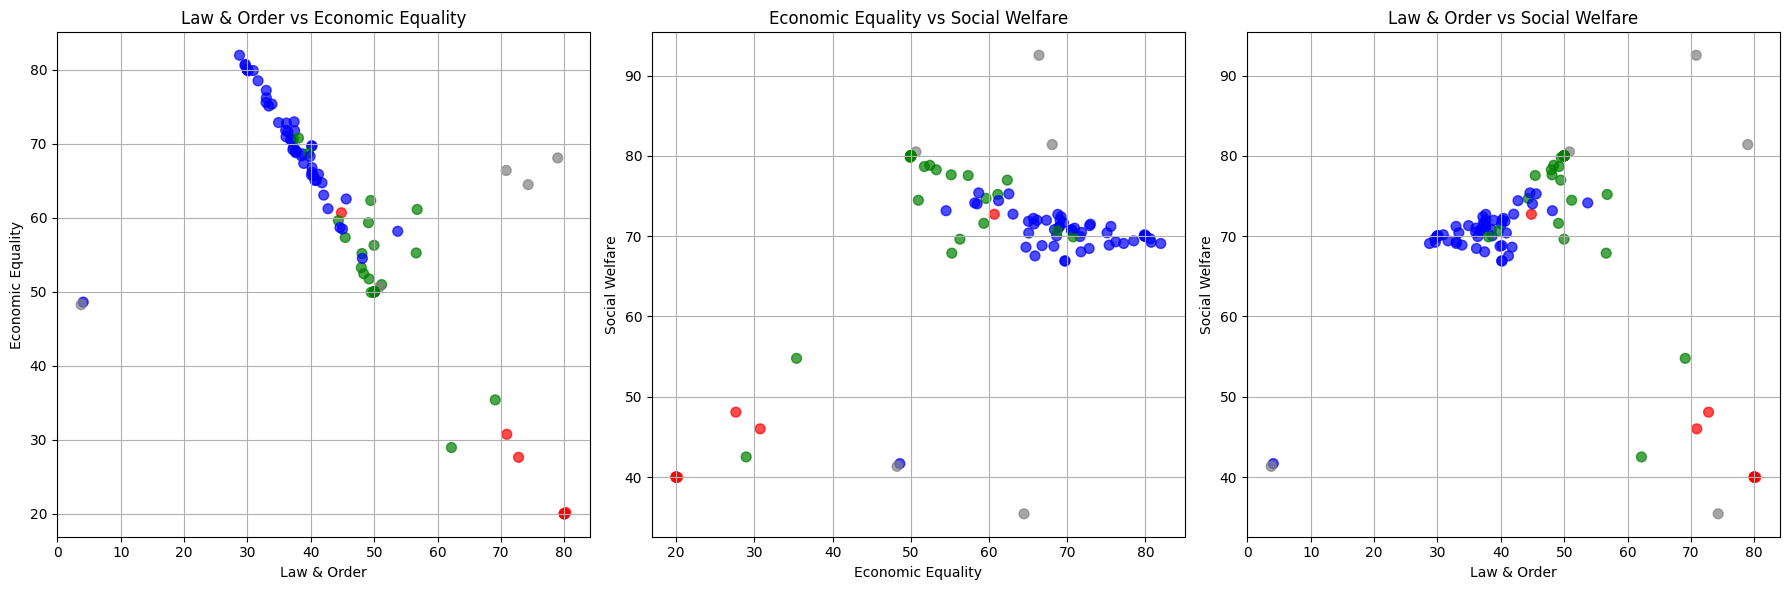

In [15]:
# Extract attributes directly
X = [agent.LawAndOrder for agent in environment.agents]
Y = [agent.EconomicEquality for agent in environment.agents]
Z = [agent.SocialWelfare for agent in environment.agents]

colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# --- XY plot (Law & Order vs Economic Equality) ---
axes[0].scatter(X, Y, c=colors, s=50, alpha=0.7)
axes[0].set_xlabel("Law & Order")
axes[0].set_ylabel("Economic Equality")
axes[0].set_title("Law & Order vs Economic Equality")
axes[0].grid(True)

# --- YZ plot (Economic Equality vs Social Welfare) ---
axes[1].scatter(Y, Z, c=colors, s=50, alpha=0.7)
axes[1].set_xlabel("Economic Equality")
axes[1].set_ylabel("Social Welfare")
axes[1].set_title("Economic Equality vs Social Welfare")
axes[1].grid(True)

# --- XZ plot (Law & Order vs Social Welfare) ---
axes[2].scatter(X, Z, c=colors, s=50, alpha=0.7)
axes[2].set_xlabel("Law & Order")
axes[2].set_ylabel("Social Welfare")
axes[2].set_title("Law & Order vs Social Welfare")
axes[2].grid(True)

plt.tight_layout()
plt.show()


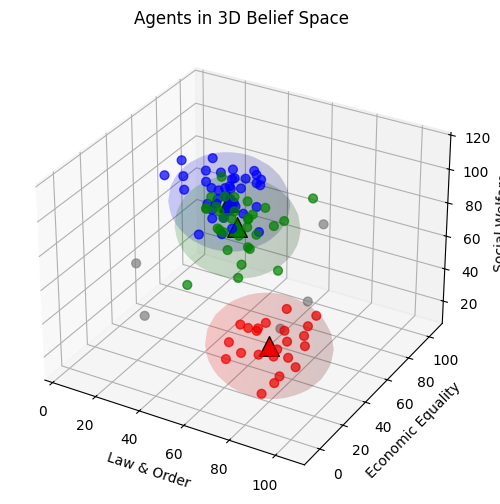

In [10]:
%matplotlib inline
# if you want to move the 3D space, change inline to widget
# Collect beliefs from all agents
X = [agent.LawAndOrder for agent in environment.agents]
Y = [agent.EconomicEquality for agent in environment.agents]
Z = [agent.SocialWelfare for agent in environment.agents]

# Color map by party
party_colors = {
    "Conservatism": "red",
    "Socialism": "blue",
    "Liberalism": "green",
    "Undecided": "gray"
}
colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

# 3D scatter
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=colors, marker='o', s=40, alpha=0.7)

# Labels
ax.set_xlabel("Law & Order")
ax.set_ylabel("Economic Equality")
ax.set_zlabel("Social Welfare")
ax.set_title("Agents in 3D Belief Space")

# --- Define helper function to draw spheres ---
def plot_sphere(ax, center, radius, color):
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_surface(x, y, z, color=color, alpha=0.1, linewidth=0)

# --- Draw each party sphere ---
for p in environment.parties:
    plot_sphere(ax, p.center_vector(), p.radius, party_colors[p.name])
    # also mark the party center
    ax.scatter(*p.center_vector(), c=party_colors[p.name], 
               marker="^", s=200, edgecolors="k")

plt.show()


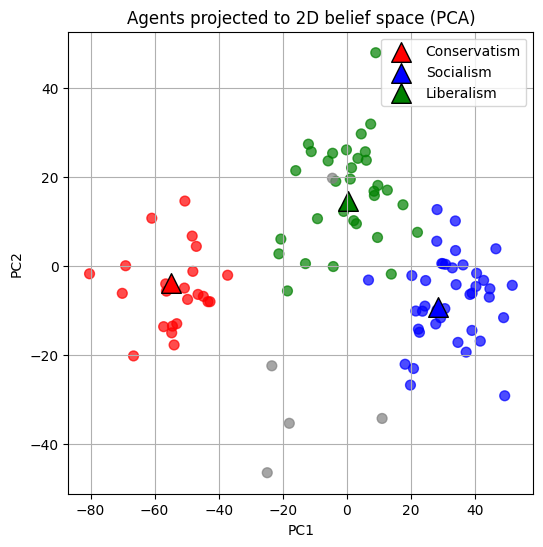

In [11]:
%matplotlib inline
# Collect all agents’ beliefs into an array
X = np.array([agent.belief_vector() for agent in environment.agents])

# Reduce to 2 components for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Color agents by party
party_colors = {
    "Conservatism": "red",
    "Socialism": "blue",
    "Liberalism": "green",
    "Undecided": "gray"
}
colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

# Project party centers into PCA space
party_centers = np.array([p.center_vector() for p in environment.parties])
party_centers_reduced = pca.transform(party_centers)

# Plot 2D projection (agents)
plt.figure(figsize=(6,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=colors, s=50, alpha=0.7)

# --- Add party centers and boundaries ---
import matplotlib.patches as patches

for i, p in enumerate(environment.parties):
    center = party_centers_reduced[i]
    # Party center
    plt.scatter(center[0], center[1],
                c=party_colors[p.name], marker="^", s=200, edgecolors="k", label=p.name)
    # Boundary circle (scaled radius for PCA space)
    #circle = patches.Circle(center, radius=p.radius*0.6,
    #                        color=party_colors[p.name], alpha=0.15, zorder=1)
    #plt.gca().add_patch(circle)

# Formatting
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agents projected to 2D belief space (PCA)")
plt.grid(True)
plt.legend()
plt.show()

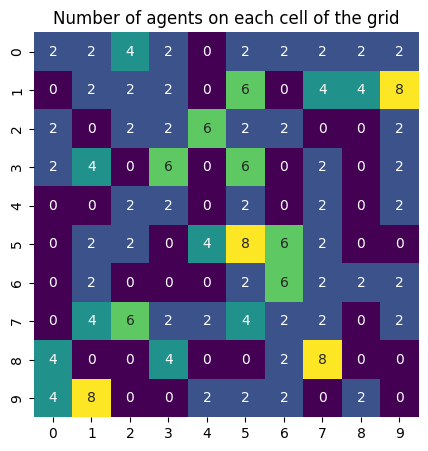

In [12]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

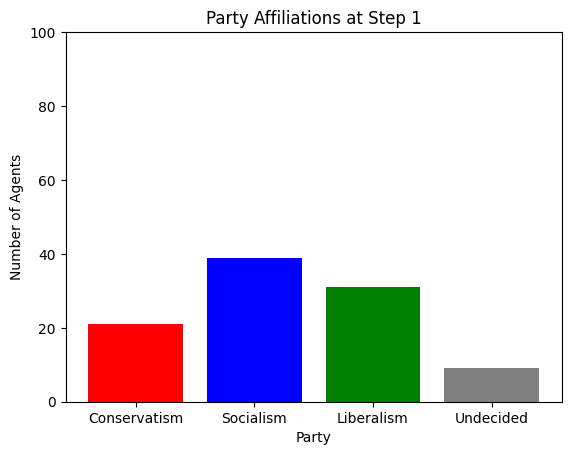

In [13]:
from IPython.display import HTML

# --- Precompute history ---
steps = 100   # number of steps you want to simulate
history = []

for step in range(steps):
    environment.step()
    # get all party affiliations each agent in each step
    votes = [agent.party_affiliation for agent in environment.agents]
    # count of party affiliations in that step; reindix ensures every party appears in the count, even if nobody voted for it (set missing ones to 0).
    vote_counts = pd.Series(votes).value_counts().reindex(
        [p.name for p in environment.parties] + ["Undecided"], fill_value=0
    )
    history.append(vote_counts)

# --- Animate from history ---
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    counts = history[i]
    ax.bar(counts.index, counts.values,
           color=[party_colors.get(p, "gray") for p in counts.index])
    ax.set_ylim(0, environment.num_agents)
    ax.set_title(f"Party Affiliations at Step {i+1}")
    ax.set_xlabel("Party")
    ax.set_ylabel("Number of Agents")

ani = FuncAnimation(fig, animate, frames=steps, interval=200, repeat=False)

# Render inline in Jupyter/VS Code
HTML(ani.to_jshtml())


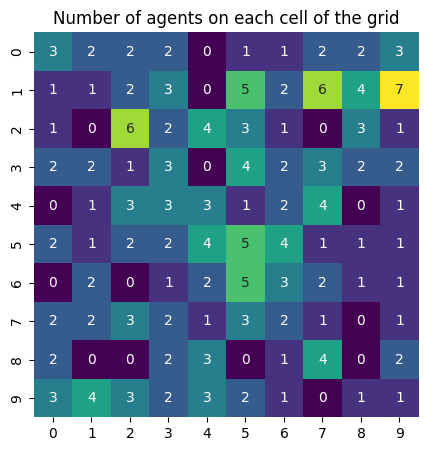

In [14]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

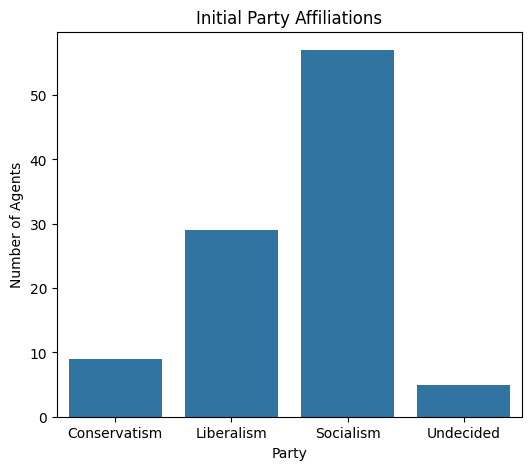

In [16]:
# Collect each agent's initial party affiliation
initial_votes = [agent.party_affiliation for agent in environment.agents]

# Count frequencies by party name
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()

# Plot
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Party Affiliations", xlabel="Party", ylabel="Number of Agents")
p.figure.set_size_inches(6, 5)


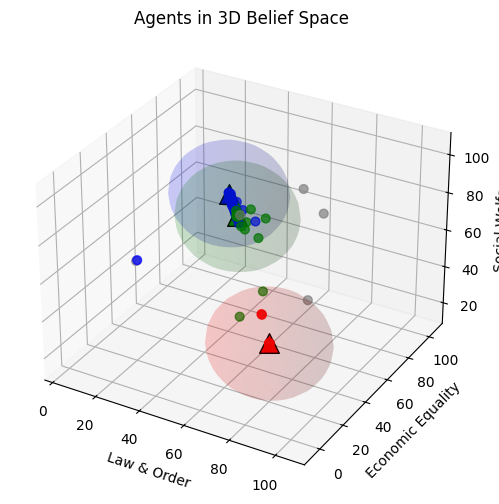

In [17]:
%matplotlib inline
# if you want to move the 3D space, change inline to widget
# Collect beliefs from all agents
X = [agent.LawAndOrder for agent in environment.agents]
Y = [agent.EconomicEquality for agent in environment.agents]
Z = [agent.SocialWelfare for agent in environment.agents]

# Color map by party
party_colors = {
    "Conservatism": "red",
    "Socialism": "blue",
    "Liberalism": "green",
    "Undecided": "gray"
}
colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

# 3D scatter
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=colors, marker='o', s=40, alpha=0.7)

# Labels
ax.set_xlabel("Law & Order")
ax.set_ylabel("Economic Equality")
ax.set_zlabel("Social Welfare")
ax.set_title("Agents in 3D Belief Space")

# --- Define helper function to draw spheres ---
def plot_sphere(ax, center, radius, color):
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_surface(x, y, z, color=color, alpha=0.1, linewidth=0)

# --- Draw each party sphere ---
for p in environment.parties:
    plot_sphere(ax, p.center_vector(), p.radius, party_colors[p.name])
    # also mark the party center
    ax.scatter(*p.center_vector(), c=party_colors[p.name], 
               marker="^", s=200, edgecolors="k")

plt.show()


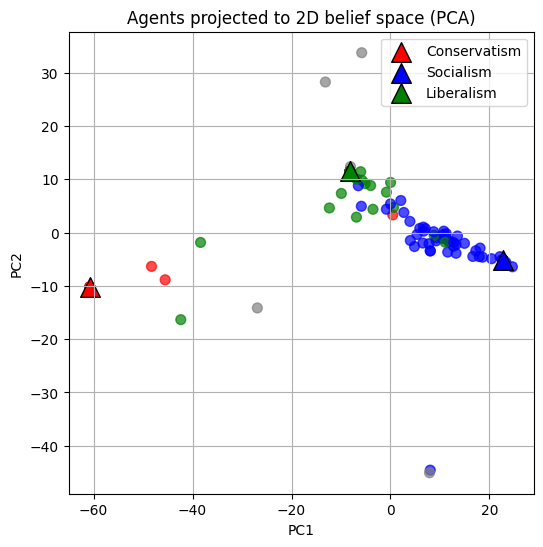

In [18]:
%matplotlib inline
# Collect all agents’ beliefs into an array
X = np.array([agent.belief_vector() for agent in environment.agents])

# Reduce to 2 components for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Color agents by party
party_colors = {
    "Conservatism": "red",
    "Socialism": "blue",
    "Liberalism": "green",
    "Undecided": "gray"
}
colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

# Project party centers into PCA space
party_centers = np.array([p.center_vector() for p in environment.parties])
party_centers_reduced = pca.transform(party_centers)

# Plot 2D projection (agents)
plt.figure(figsize=(6,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=colors, s=50, alpha=0.7)

# --- Add party centers and boundaries ---
import matplotlib.patches as patches

for i, p in enumerate(environment.parties):
    center = party_centers_reduced[i]
    # Party center
    plt.scatter(center[0], center[1],
                c=party_colors[p.name], marker="^", s=200, edgecolors="k", label=p.name)
    # Boundary circle (scaled radius for PCA space)
    #circle = patches.Circle(center, radius=p.radius*0.6,
    #                        color=party_colors[p.name], alpha=0.15, zorder=1)
    #plt.gca().add_patch(circle)

# Formatting
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Agents projected to 2D belief space (PCA)")
plt.grid(True)
plt.legend()
plt.show()

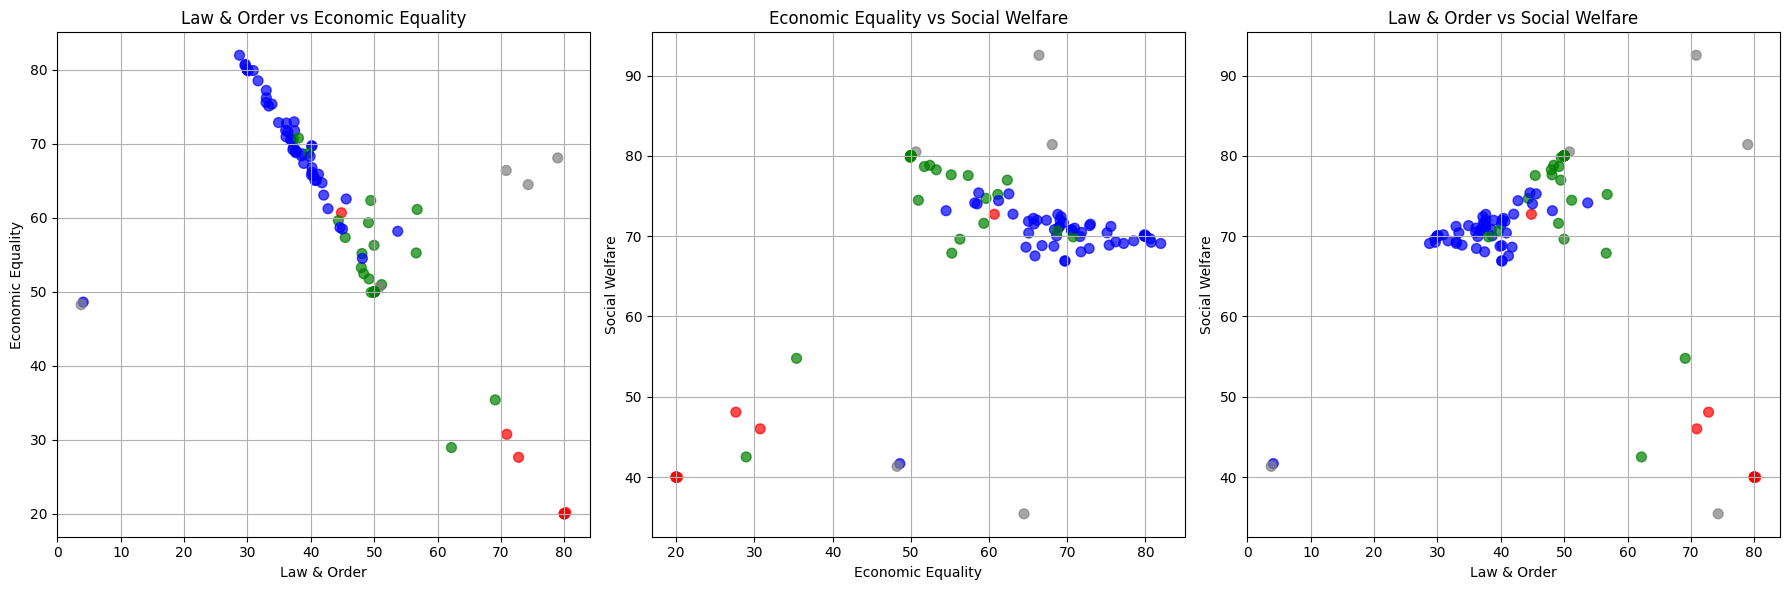

In [19]:
# Extract attributes directly
X = [agent.LawAndOrder for agent in environment.agents]
Y = [agent.EconomicEquality for agent in environment.agents]
Z = [agent.SocialWelfare for agent in environment.agents]

colors = [party_colors[agent.party_affiliation] for agent in environment.agents]

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# --- XY plot (Law & Order vs Economic Equality) ---
axes[0].scatter(X, Y, c=colors, s=50, alpha=0.7)
axes[0].set_xlabel("Law & Order")
axes[0].set_ylabel("Economic Equality")
axes[0].set_title("Law & Order vs Economic Equality")
axes[0].grid(True)

# --- YZ plot (Economic Equality vs Social Welfare) ---
axes[1].scatter(Y, Z, c=colors, s=50, alpha=0.7)
axes[1].set_xlabel("Economic Equality")
axes[1].set_ylabel("Social Welfare")
axes[1].set_title("Economic Equality vs Social Welfare")
axes[1].grid(True)

# --- XZ plot (Law & Order vs Social Welfare) ---
axes[2].scatter(X, Z, c=colors, s=50, alpha=0.7)
axes[2].set_xlabel("Law & Order")
axes[2].set_ylabel("Social Welfare")
axes[2].set_title("Law & Order vs Social Welfare")
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Dynamic Visualisation

In [33]:
def agent_portrayal(agent):
    c = party_colors.get(agent.party_affiliation, "gray")
    return AgentPortrayalStyle(color=c, marker="o", size=50)

social_contagion = Environment(n=5, width=3, height=3)  # keyword arguments

In [34]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 5,
        "label": "Number of agents:",
        "min": 3,
        "max": 6,
        "step": 1,
    },
    "width": 3,
    "height": 3
}

In [35]:
%%capture

renderer = SpaceRenderer(model=social_contagion, backend="matplotlib")
renderer.draw_structure(lw=2, ls="solid", color="black", alpha=0.1)
renderer.draw_agents(agent_portrayal)

In [36]:
def post_process(ax):
    """Customize the matplotlib axes after rendering."""
    ax.set_title("Social Contagion Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("equal", adjustable="box")


renderer.post_process = post_process

In [37]:
page = SolaraViz(
    social_contagion,
    renderer,
    #components=[BiasPlot],
    model_params=model_params,
    name="Social Contagion ABM",
)

# This is required to render the visualization in a Jupyter notebook
page

Cannot show ipywidgets in text

In [38]:
df = social_contagion.datacollector.get_model_vars_dataframe()
print(df[["vote_Conservatism", "vote_Socialism", "vote_Liberalism", "vote_Undecided"]].head(30))


    vote_Conservatism  vote_Socialism  vote_Liberalism  vote_Undecided
0                   2               1                1               0
1                   2               1                1               0
2                   2               1                1               0
3                   2               1                1               0
4                   1               2                1               0
5                   1               2                1               0
6                   0               3                1               0
7                   0               3                1               0
8                   0               2                2               0
9                   0               2                2               0
10                  0               3                1               0


In [39]:
agent_df = social_contagion.datacollector.get_agent_vars_dataframe()

In [40]:
agent_data = social_contagion.datacollector.get_agent_vars_dataframe()
display(agent_data.head())

belief_vector  \
Step AgentID                                                      
0    1        [71.68795289467921, 9.51075498292167, 41.12960...   
     2        [59.25278794646033, -4.200890643097296, 52.146...   
     3        [43.54350984766107, 68.45624424264847, 74.8161...   
     4        [63.03434035600067, 46.18331223562161, 72.7351...   
1    1        [45.75769260312944, 63.81887815181865, 72.1659...   

              distance_from_party         party  susceptibility  switched  \
Step AgentID                                                                
0    1                  13.430949  Conservatism        0.921328     False   
     2                  34.112621  Conservatism        0.992572     False   
     3                  18.435841     Socialism        0.008233     False   
     4                  15.402591    Liberalism        0.229590     False   
1    1                  13.430949  Conservatism        0.921328     False   

              has_interacted  interacted_with  
Step AgentID                                   
0    1                 False              NaN  
     2                 False              NaN  
     3                 False              NaN  
     4                 False              NaN  
1    1                  True              3.0

In [41]:
dist_party_df = agent_df[["distance_from_party", "party", "interacted_with", "switched", "belief_vector"]]
dist_party_unstacked = dist_party_df.unstack(level="AgentID")
display(dist_party_unstacked)

distance_from_party                                          party  \
AgentID                   1          2          3          4             1   
Step                                                                         
0                 13.430949  34.112621  18.435841  15.402591  Conservatism   
1                 13.430949  34.112621  18.284052  15.402591  Conservatism   
2                 13.430949  34.112621  18.284052  11.866304  Conservatism   
3                 13.430949  34.112621  18.284052   9.141915  Conservatism   
4                 13.430949  22.874426  18.284052   9.141915  Conservatism   
5                 13.430949  22.874426  18.284052   9.141915  Conservatism   
6                 24.662476  22.874426  17.984214   9.141915     Socialism   
7                 18.475752  22.874426  17.984214   9.141915     Socialism   
8                 12.514626  22.874426  17.689293   9.141915    Liberalism   
9                 12.514626  22.874426  17.543651   9.141915    Liberalism   
10                18.744916  22.874426  17.543651   4.180250     Socialism   

                                             interacted_with                 \
AgentID             2          3           4               1    2    3    4   
Step                                                                          
0        Conservatism  Socialism  Liberalism             NaN  NaN  NaN  NaN   
1        Conservatism  Socialism  Liberalism             3.0  NaN  1.0  NaN   
2        Conservatism  Socialism  Liberalism             3.0  4.0  1.0  2.0   
3        Conservatism  Socialism  Liberalism             3.0  4.0  4.0  3.0   
4           Socialism  Socialism  Liberalism             2.0  1.0  4.0  3.0   
5           Socialism  Socialism  Liberalism             2.0  1.0  4.0  3.0   
6           Socialism  Socialism  Liberalism             2.0  1.0  4.0  3.0   
7           Socialism  Socialism  Liberalism             3.0  1.0  1.0  3.0   
8           Socialism  Socialism  Liberalism             2.0  1.0  4.0  3.0   
9           Socialism  Socialism  Liberalism             3.0  1.0  1.0  3.0   
10          Socialism  Socialism  Liberalism             2.0  1.0  4.0  3.0   

        switched                       \
AgentID        1      2      3      4   
Step                                    
0          False  False  False  False   
1          False  False  False  False   
2          False  False  False  False   
3          False  False  False  False   
4          False   True  False  False   
5          False  False  False  False   
6           True  False  False  False   
7          False  False  False  False   
8           True  False  False  False   
9          False  False  False  False   
10          True  False  False  False   

                                             belief_vector  \
AgentID                                                  1   
Step                                                         
0        [71.68795289467921, 9.51075498292167, 41.12960...   
1        [45.75769260312944, 63.81887815181865, 72.1659...   
2        [45.75769260312944, 63.81887815181865, 72.1659...   
3        [45.75769260312944, 63.81887815181865, 72.1659...   
4        [61.64927177399805, 47.22594616051371, 72.5494...   
5        [61.64927177399805, 47.22594616051371, 72.5494...   
6        [47.125953436880216, 62.39023102262641, 72.198...   
7        [43.51967143179034, 68.23956057194968, 74.5015...   
8        [60.11510402296301, 48.99176624867613, 72.7004...   
9        [44.34194233631527, 67.35561438866162, 74.4700...   
10       [43.70762593044197, 68.02705319091682, 74.4856...   

                                                            \
AgentID                                                  2   
Step                                                         
0        [59.25278794646033, -4.200890643097296, 52.146...   
1        [59.25278794646033, -4.200890643097296, 52.146...   
2        [63.006252388988806, 45.80907708690168, 72.58

In [53]:
print(agent_df.index.get_level_values("AgentID").unique()[:10])


Index([1, 2, 3, 4], dtype='int64', name='AgentID')


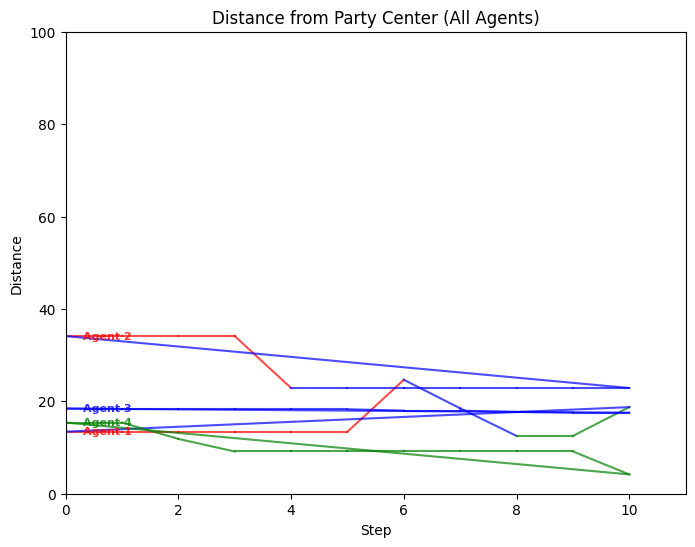

In [57]:
from IPython.display import HTML

# --- Agent IDs directly from dataframe ---
agent_ids = agent_df.index.get_level_values("AgentID").unique()
total_steps = agent_df.index.get_level_values("Step").nunique()

# --- Storage dictionaries per agent ---
steps_x = {agent_id: [] for agent_id in agent_ids}
distances_y = {agent_id: [] for agent_id in agent_ids}

# --- Create figure ---
fig, ax = plt.subplots(figsize=(8,6))

def animate(i):
    ax.clear()
    ax.set_ylim(0, 100)
    ax.set_xlim(0, total_steps)
    ax.set_title("Distance from Party Center (All Agents)")
    ax.set_xlabel("Step")
    ax.set_ylabel("Distance")

    # For every agent, record and plot their path
    for agent_id in agent_ids:
        # record
        steps_x[agent_id].append(i)
        dist = agent_df.loc[(i, agent_id), "distance_from_party"]
        distances_y[agent_id].append(dist)

        # redraw segments with party color
        for j in range(len(steps_x[agent_id]) - 1):
            p = agent_df.loc[(steps_x[agent_id][j], agent_id), "party"]
            seg_color = party_colors.get(p, "gray")
            ax.plot(
                steps_x[agent_id][j:j+2],
                distances_y[agent_id][j:j+2],
                color=seg_color,
                alpha=0.7
            )

        # Draw the agent label near the latest point
        if steps_x[agent_id]:
            latest_x = steps_x[agent_id][-1]
            latest_y = distances_y[agent_id][-1]
            party_now = agent_df.loc[(i, agent_id), "party"]
            label_color = party_colors.get(party_now, "gray")

            ax.text(
                latest_x + 0.3, latest_y,
                f"Agent {agent_id}",
                color=label_color,
                fontsize=8,
                ha="left", va="center",
                alpha=0.8,
                fontweight="bold"
            )


# --- Build animation ---
ani = FuncAnimation(fig, animate, frames=total_steps, interval=200, repeat=False)

# --- Render inline ---
HTML(ani.to_jshtml())


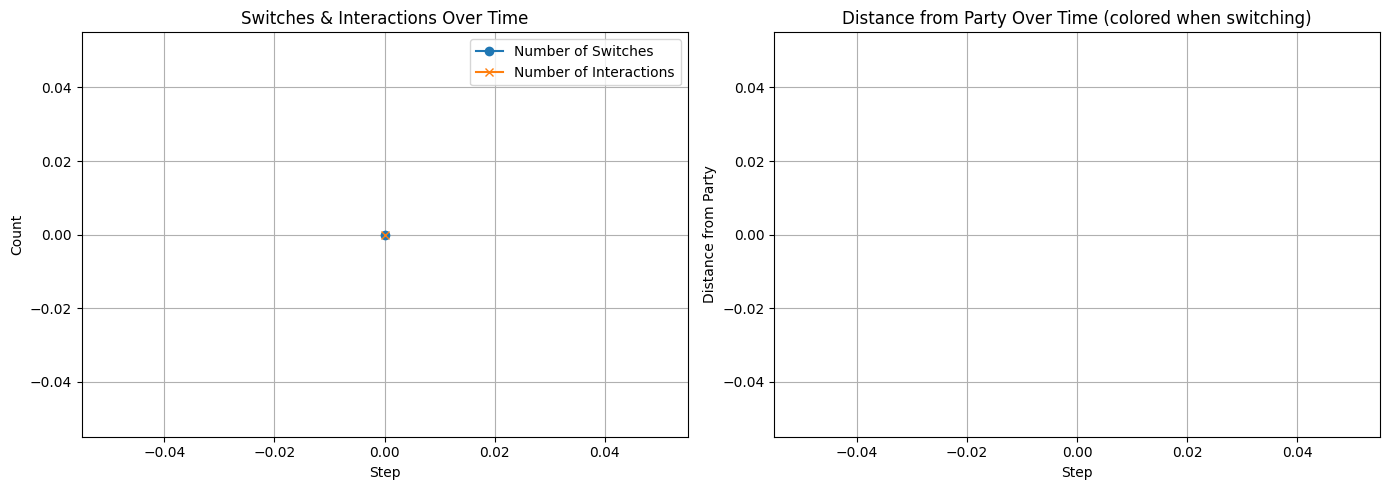

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# After you’ve run your model:
df = social_contagion.datacollector.get_model_vars_dataframe()
steps = df.index  # define steps

# Also retrieve the agent data and unstack:
agent_df = social_contagion.datacollector.get_agent_vars_dataframe()
dist_by_agent = agent_df["distance_from_party"].unstack(level="AgentID")
switch_df = agent_df["switched"].unstack(level="AgentID")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Left plot: switches & interactions
ax0 = axes[0]
ax0.plot(steps, df["num_switches"], label="Number of Switches", marker="o")
ax0.plot(steps, df["num_interactions"], label="Number of Interactions", marker="x")
ax0.set_xlabel("Step")
ax0.set_ylabel("Count")
ax0.set_title("Switches & Interactions Over Time")
ax0.legend()
ax0.grid(True)

# Right plot: distance from party with colored switching segments
ax1 = axes[1]

for agent_id in dist_by_agent.columns:
    y = dist_by_agent[agent_id].values
    x = dist_by_agent.index.values  # these are your steps

    # Create line segments between consecutive (x, y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Decide color per segment — check switch_df at the destination step
    colors = []
    for i in range(len(x) - 1):
        sw = switch_df.loc[x[i+1], agent_id]
        colors.append("red" if sw else "blue")

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    ax1.add_collection(lc)

# Optionally draw a horizontal threshold line, e.g. at y = 0 (or any value)
threshold = 0
ax1.hlines(y=threshold,
           xmin=dist_by_agent.index.min(),
           xmax=dist_by_agent.index.max(),
           colors="gray", linestyles="--", linewidth=1)

ax1.set_xlabel("Step")
ax1.set_ylabel("Distance from Party")
ax1.set_title("Distance from Party Over Time (colored when switching)")
ax1.autoscale()
ax1.grid(True)

plt.tight_layout()
plt.show()
